# Parameterization and Waveform Differences

GWCorrect v0.17.0.5

In this tutorial, we demonstrate using this package to load in and use parameterized sets of waveform differences as well as how to generate these sets ourselves. This notebook can be downloaded [here](https://github.com/RyanSR71/waveform_uncertainty/blob/main/docs/source/notebooks/Parameterization_and_Waveform_Differences.ipynb).

The following cell is everything we need to import to run this tutorial. We also import the `GWCorrect` package, which will need to be installed first. See [Installation](https://waveformuncertainty.readthedocs.io/en/latest/installation.html#installation).

In [2]:
import os
import numpy as np
import bilby
import matplotlib.pyplot as plt
import sys
import scipy
import lal
import random
from pesummary.gw.file.strain import StrainData
from pesummary.io import read
import requests
import pandas
import GWCorrect as gwc

## Using Parameterized Waveform Differences

We will first demonstrate how parameterized waveform differences are loaded in and used. Here, we load in `BBH_parameterization_nsamples1000.npy`, which contains 1000 samples of parameterized amplitude differences and phase differences from simulated binary black hole merger events.

In [3]:
# downloading the file and saving to a folder
try:
    os.mkdir('tutorial_files')
except:
    pass
file = requests.get('https://github.com/RyanSR71/waveform_uncertainty/raw/refs/heads/main/files/BBH_parameterization_nsamples1000.npy', allow_redirects=True)
open("tutorial_files/BBH_parameterization_nsamples1000.npy", 'wb').write(file.content)

# loading the file
parameterization = np.load("tutorial_files/BBH_parameterization_nsamples1000.npy",allow_pickle=True)

We can use `GWCorrect.parameterization.recovery_from_parameterization` to turn the parameterized sets of waveform differences back into the waveform differences they represent. This function takes in one row of the parameterization array and constructs the waveform differences from the spline parameters in the file. The function returns the frequency array, amplitude difference array, and phase difference array. By default, the frequency array is given in standard frequency units (Hz). This can be changed by changing the `dimensionless` kwarg to `True`.

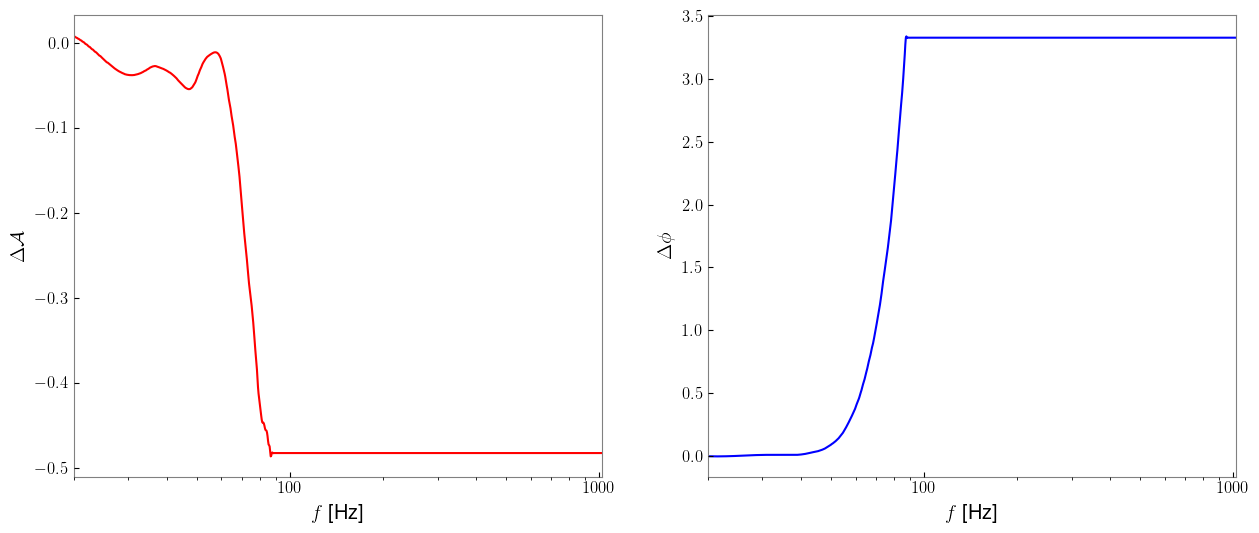

In [4]:
# we can choose any index to recover up to the number of sample sets in the file; in this case, 1000
index = random.randint(0,1000)

# recovering a draw of waveform differences
frequency_grid, amplitude_difference, phase_difference = gwc.parameterization.recovery_from_parameterization(parameterization[index])

# plotting
fig,ax = plt.subplots(1,2,figsize=(15,6))

# plotting the waveform differences
ax[0].semilogx(frequency_grid,amplitude_difference,color='red')
ax[1].semilogx(frequency_grid,phase_difference,color='blue')

# plot settings
ax[0].grid(False)
ax[0].set_xlabel(r'$f$ [Hz]')
ax[0].set_ylabel(r'$\Delta\mathcal{A}$')
ax[0].tick_params(direction='in')
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])

ax[1].grid(False)
ax[1].set_xlabel(r'$f$ [Hz]')
ax[1].set_ylabel(r'$\Delta\phi$')
ax[1].tick_params(direction='in')
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])

plt.show()

From a parameterization file, we can use `GWCorrect.parameterization.uncertainties_from_parameterization` to find the means and standard deviations of each waveform difference, which will show us the expected variability between the waveform models. We represent the means as $\overline{\Delta\mathcal{A}}_\mu$ and $\overline{\Delta\phi}_\mu$, and the standard deviations as $\delta\mathcal{A}_\mu$ and $\delta\phi_\mu$.

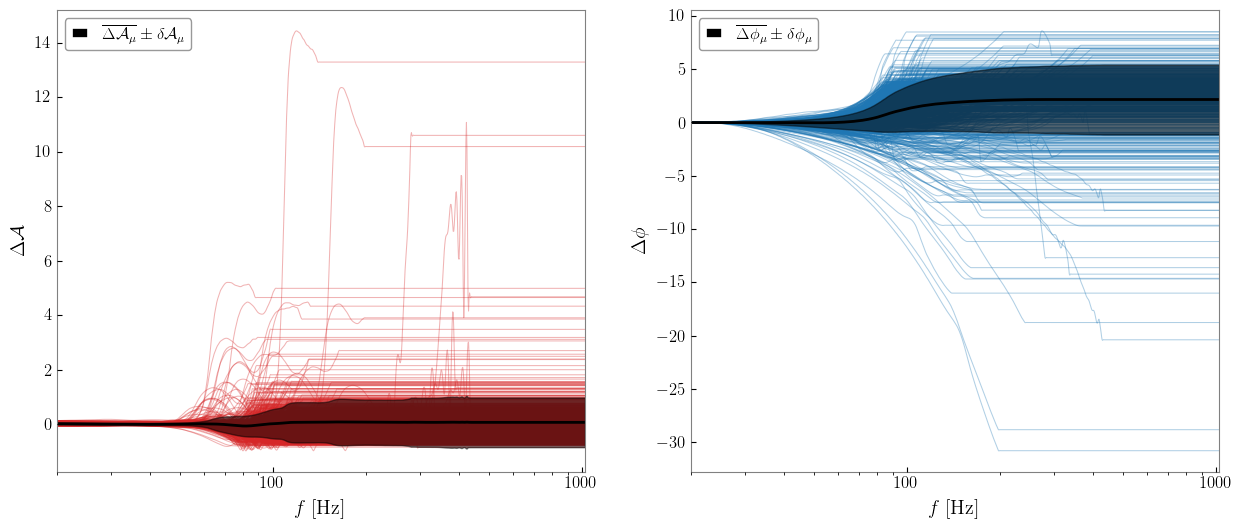

In [5]:
# finding the means and standard deviations
mean_amplitude_difference,amplitude_uncertainty,mean_phase_difference,phase_uncertainty = gwc.parameterization.uncertainties_from_parameterization(parameterization)

# plotting
fig,ax = plt.subplots(1,2,figsize=(15,6))

# plotting the means and standard deviations (uncertainties)
ax[0].semilogx(frequency_grid,mean_amplitude_difference,color='k',linewidth=2,zorder=2,label=r'$\overline{\Delta\mathcal{A}_{\mu}}\pm\delta\mathcal{A}_{\mu}$')
ax[0].fill_between(frequency_grid,mean_amplitude_difference-amplitude_uncertainty,mean_amplitude_difference+amplitude_uncertainty,color='k',alpha=0.5,zorder=2)
ax[1].semilogx(frequency_grid,mean_phase_difference,color='k',linewidth=2,zorder=2,label=r'$\overline{\Delta\phi_{\mu}}\pm\delta\phi_{\mu}$')
ax[1].fill_between(frequency_grid,mean_phase_difference-phase_uncertainty,mean_phase_difference+phase_uncertainty,color='k',alpha=0.5,zorder=2)

# plotting all of the draws of waveform difference
for i in range(len(parameterization)):
    frequency_grid, amplitude_difference, phase_difference = gwc.parameterization.recovery_from_parameterization(parameterization[i])
    ax[0].semilogx(frequency_grid,amplitude_difference,color='tab:red',linewidth=0.75,alpha=0.35,zorder=1)
    ax[1].semilogx(frequency_grid,phase_difference,color='tab:blue',linewidth=0.75,alpha=0.35,zorder=1)

# plot settings
ax[0].legend(fancybox=True,loc='upper left')
ax[0].grid(False)
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$f\ [\mathrm{Hz}]$')
ax[0].set_ylabel(r'$\Delta\mathcal{A}$')
ax[0].tick_params(direction='in')

ax[1].legend(fancybox=True,loc='upper left')
ax[1].grid(False)
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$f\ [\mathrm{Hz}]$')
ax[1].set_ylabel(r'$\Delta\phi$')
ax[1].tick_params(direction='in')

plt.show()

We can also perform this same operation in dimensionless frequency, $\xi$. To do so, we simply set `dimensionless=True` in both the `GWCorrect.parameterization.recovery_from_parameterization` and `GWCorrect.parameterization.uncertainties_from_parameterization` functions. In doing this, we essentially remove the total mass contributions from the waveform differences, and we are left with smaller overall distributions. This is useful for defining more constrained priors.

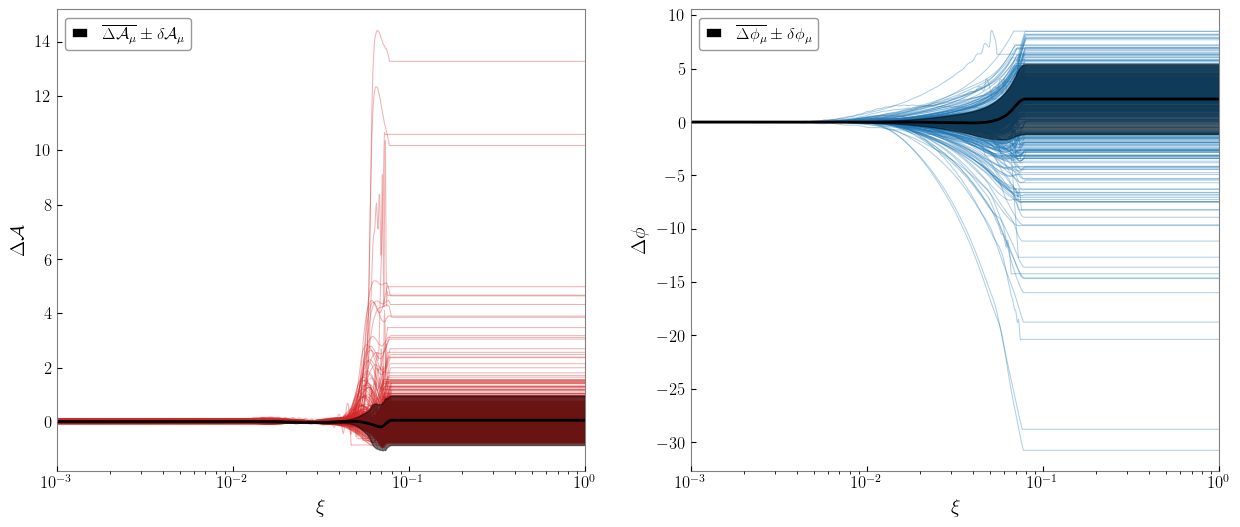

In [6]:
# finding the means and standard deviations
mean_amplitude_difference,amplitude_uncertainty,mean_phase_difference,phase_uncertainty = gwc.parameterization.uncertainties_from_parameterization(parameterization,dimensionless=True)

# plotting
fig,ax = plt.subplots(1,2,figsize=(15,6))

# plotting the means and standard deviations (uncertainties)
frequency_grid = np.geomspace(0.001,1,1000)
ax[0].semilogx(frequency_grid,mean_amplitude_difference,color='k',linewidth=2,zorder=2,label=r'$\overline{\Delta\mathcal{A}_{\mu}}\pm\delta\mathcal{A}_{\mu}$')
ax[0].fill_between(frequency_grid,mean_amplitude_difference-amplitude_uncertainty,mean_amplitude_difference+amplitude_uncertainty,color='k',alpha=0.5,zorder=2)
ax[1].semilogx(frequency_grid,mean_phase_difference,color='k',linewidth=2,zorder=2,label=r'$\overline{\Delta\phi_{\mu}}\pm\delta\phi_{\mu}$')
ax[1].fill_between(frequency_grid,mean_phase_difference-phase_uncertainty,mean_phase_difference+phase_uncertainty,color='k',alpha=0.5,zorder=2)

# plotting all of the draws of waveform difference
for i in range(len(parameterization)):
    frequency_grid, amplitude_difference, phase_difference = gwc.parameterization.recovery_from_parameterization(parameterization[i],dimensionless=True)
    ax[0].semilogx(frequency_grid,amplitude_difference,color='tab:red',linewidth=0.75,alpha=0.35,zorder=1)
    ax[1].semilogx(frequency_grid,phase_difference,color='tab:blue',linewidth=0.75,alpha=0.35,zorder=1)

# plot settings
ax[0].legend(fancybox=True,loc='upper left')
ax[0].grid(False)
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\xi$')
ax[0].set_ylabel(r'$\Delta\mathcal{A}$')
ax[0].tick_params(direction='in')

ax[1].legend(fancybox=True,loc='upper left')
ax[1].grid(False)
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\xi$')
ax[1].set_ylabel(r'$\Delta\phi$')
ax[1].tick_params(direction='in')

plt.show()

## Generating Waveform Model Differences

In the following sections, we look at generating waveform differences and then generating a parameterization file.

We first construct a prior of source parameters over which we want to generate waveform differences. Here, we choose a prior for binary black hole analysis.

In [7]:
prior = bilby.core.prior.PriorDict()

prior['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass',latex_label=r'$\mathcal{M}_c$',minimum=25,maximum=100,unit=r'$\mathrm{M}_{\odot}$')
prior['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio',latex_label=r'$q$',minimum=0.125,maximum=1)
prior['chi_1'] = bilby.core.prior.Uniform(name='chi_1',latex_label=r'$\chi_1$',minimum=-1,maximum=1)
prior['chi_2'] = bilby.core.prior.Uniform(name='chi_2',latex_label=r'$\chi_2$',minimum=-1,maximum=1)
prior['geocent_time'] = bilby.core.prior.Uniform(name='geocent_time',latex_label=r'$t_{c}$',minimum=1126259462.3,maximum=1126259462.5,unit='s')
prior['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance',latex_label=r'$D_L$',minimum=100,maximum=10000,unit='Mpc')
prior['phase'] = bilby.core.prior.Uniform(name='phase',latex_label=r'$\phi_\mathrm{ref}$',minimum=0,maximum=2*np.pi,boundary='periodic')
prior['theta_jn'] = bilby.core.prior.Sine(name='theta_jn',latex_label=r'$\theta_{JN}$')

Here we set up our waveform generators with our injection passed as an argument. Because we are looking to generate model differences, we choose two different waveform approximants, `IMRPhenomD` and `SEOBNRv4`.

In [8]:
waveform_arguments_1 = dict(waveform_approximant='IMRPhenomD', reference_frequency=50, 
                            catch_waveform_errors=True, minimum_frequency=20.0, maximum_frequency=1024.0)

hf1 = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_1,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    sampling_frequency=4096, 
                    duration=4,
                )

waveform_arguments_2 = dict(waveform_approximant='SEOBNRv4', reference_frequency=50, 
                            catch_waveform_errors=True, minimum_frequency=20.0, maximum_frequency=1024.0)

hf2 = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_2,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    sampling_frequency=4096, 
                    duration=4,
                )

12:33 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
12:33 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


With the waveform generators, we can calculate the waveform model differences, $\Delta\mathcal{A}_{\mu}$ and $\Delta\phi_{\mu}$. If we pass the waveform generators into the `GWCorrect.parameterization.fd_model_difference` function, it will return model amplitude difference, $\Delta\mathcal{A}_{\mu}$, and unaligned model phase difference, $\Delta{\phi}_{\mu}^\mathrm{unaligned}$.

If injection parameters are not present in the waveform generators, add them to the `fd_model_difference` function as a kwarg.

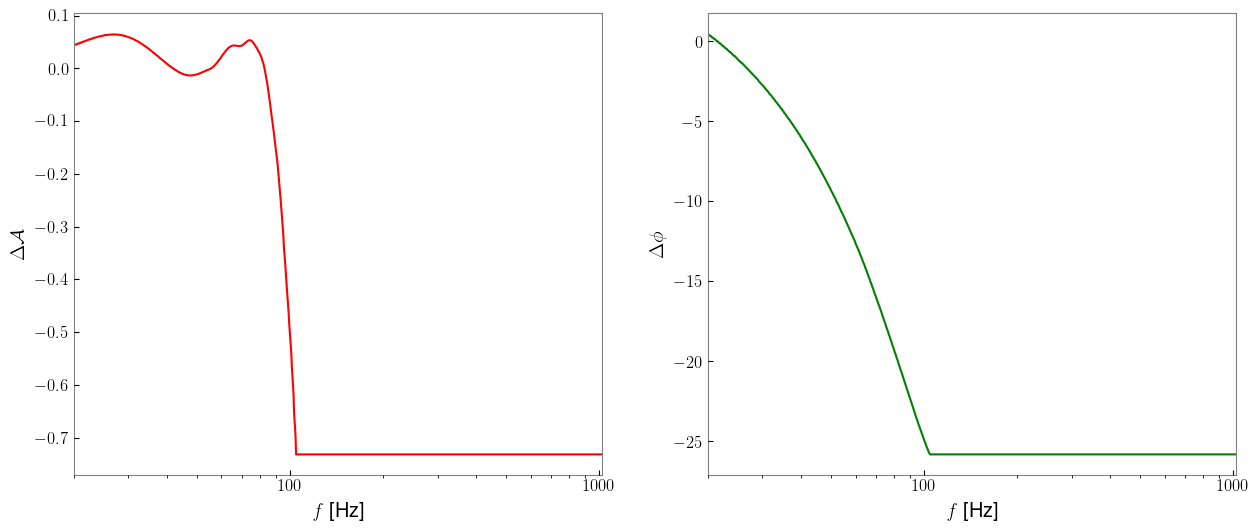

In [9]:
# calculating the waveform model differences

injection=prior.sample()

frequency_grid,amplitude_difference,unaligned_phase_difference = gwc.parameterization.fd_model_difference(hf1,hf2,injection=injection)

# plotting
fig,ax = plt.subplots(1,2,figsize=(15,6))

# plotting the waveform differences
ax[0].semilogx(frequency_grid,amplitude_difference,color='red')
ax[1].semilogx(frequency_grid,unaligned_phase_difference,color='green')

# plot settings
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$ [Hz]')
ax[0].set_ylabel(r'$\Delta\mathcal{A}$')
ax[0].tick_params(direction='in')
ax[0].grid(False)

ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$ [Hz]')
ax[1].set_ylabel(r'$\Delta\phi$')
ax[1].tick_params(direction='in')
ax[1].grid(False)

plt.show()

If power spectral density (PSD) data is passed as a kwarg `psd_data`, residual/aligned phase difference, $\Delta\phi_{\mu}$, will be returned instead of unaligned phase difference. We load in GW170817 PSD data from [LIGO DCC](https://dcc.ligo.org/login/index.shtml).

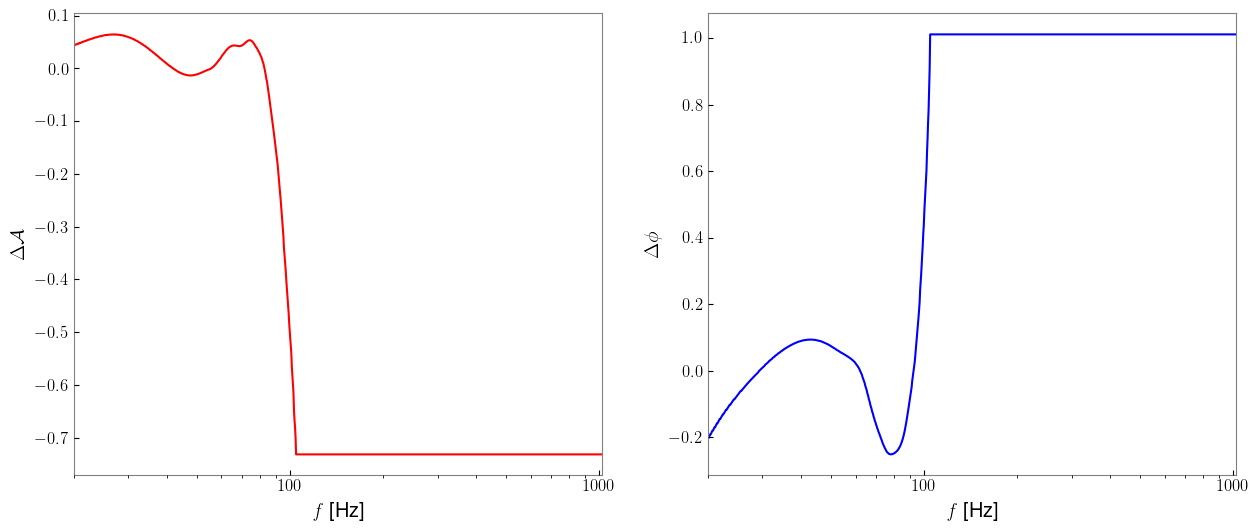

In [10]:
psd_data = np.loadtxt('https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW170817_PSDs.dat',comments='#')

frequency_grid,amplitude_difference,aligned_phase_difference = gwc.parameterization.fd_model_difference(hf1,hf2,injection=injection,psd_data=psd_data)

# plotting
fig,ax = plt.subplots(1,2,figsize=(15,6))

# plotting the waveform differences
ax[0].semilogx(frequency_grid,amplitude_difference,color='red')
ax[1].semilogx(frequency_grid,aligned_phase_difference,color='blue')

# plot settings
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$ [Hz]')
ax[0].set_ylabel(r'$\Delta\mathcal{A}$')
ax[0].tick_params(direction='in')
ax[0].grid(False)

ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$ [Hz]')
ax[1].set_ylabel(r'$\Delta\phi$')
ax[1].tick_params(direction='in')
ax[1].grid(False)

plt.show()

## Generating a Parameterization File

`GWCorrect.parameterization.parameterization` takes the previous steps and iterates them many times, but fits a cubic spline function to the waveform differences and saves the spline parameters and the injection parameters in a numpy array. To run the function, we pass two waveform generators, a prior, and the number of draws we want.

Here we define some waveform generators, each with different waveform approximants:

In [11]:
waveform_arguments_1 = dict(waveform_approximant='IMRPhenomD', reference_frequency=50, 
                            catch_waveform_errors=True, minimum_frequency=20.0, maximum_frequency=1024.0)

IMR_waveform = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_1,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    sampling_frequency=4096, 
                    duration=4,
                )

waveform_arguments_2 = dict(waveform_approximant='SEOBNRv4', reference_frequency=50, 
                            catch_waveform_errors=True, minimum_frequency=20.0, maximum_frequency=1024.0)

EOB_waveform = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_2,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    sampling_frequency=4096, 
                    duration=4,
                )

Because we want to use this file to construct a waveform uncertainty prior later, we will need to define a new prior. When perform parameter estimation, we need to constrict the total mass to ensure that our waveform uncertainty correction stays inside the frequency band. To be as accurate as possible, we want this restriction to be reflected in the prior.

In [12]:
# we pass the total mass conversion function into the PriorDict() function. this will allow bilby to convert between the given mass parameters and total mass
prior = bilby.core.prior.PriorDict(conversion_function=gwc.prior.total_mass_conversion)

# here we put in the total mass constraint prior, making sure to use the upper and lower frequencies that we set in the waveform generators
prior['total_mass'] = gwc.prior.TotalMassConstraint(name='total_mass',latex_label=r'$M$',f_low=20,f_high=1024,unit=r'$\mathrm{M}_{\odot}$')

prior['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass',latex_label=r'$\mathcal{M}_c$',minimum=25,maximum=100,unit=r'$\mathrm{M}_{\odot}$')
prior['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio',latex_label=r'$q$',minimum=0.125,maximum=1)
prior['chi_1'] = bilby.gw.prior.AlignedSpin(name='chi_1',latex_label=r'$\chi_1$')
prior['chi_2'] = bilby.gw.prior.AlignedSpin(name='chi_2',latex_label=r'$\chi_2$')
prior['geocent_time'] = bilby.gw.prior.Uniform(name='geocent_time',latex_label=r'$t_{c}$',minimum=1126259462.3,maximum=1126259462.5,unit='s')
prior['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance',latex_label=r'$D_L$',minimum=100,maximum=10000,unit='Mpc')
prior['phase'] = bilby.core.prior.Uniform(name='phase',latex_label=r'$\phi_\mathrm{ref}$',minimum=0,maximum=2*np.pi,boundary='periodic')
prior['theta_jn'] = bilby.core.prior.Sine(name='theta_jn',latex_label=r'$\theta_{JN}$')

Now we can generate the parameterization file, passing in both waveform generators and the prior. We choose our sample size to be 25 for this demonstration, and we pass in PSD data to generate aligned phase differences.

In [13]:
psd_data = np.loadtxt('https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW170817_PSDs.dat',comments='#')
parameterization=gwc.parameterization.parameterization(IMR_waveform,EOB_waveform,prior,25,psd_data=psd_data)

Generating Waveform Differences: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


This can then be saved as a `.npy` file using `numpy.save`.

In [14]:
try:
    os.mkdir('tutorial_files')
except:
    pass

np.save('tutorial_files/parameterization_example.npy',parameterization)

We can use [pandas](https://pandas.pydata.org/) dataframes to see the structure of the parameterization table:

In [15]:
pandas.DataFrame(parameterization)

,0,1,2,3,4
0,"[20.0, 20.078948998975747, 20.158209645173454,...","[20.0, 20.158209645173454, 20.31767080493819, ...","[0.02078660770468832, 0.020291733823181834, 0....","[-0.005056077354874899, -0.005249904805044725,...","{'chirp_mass': 68.8696285955517, 'mass_ratio':..."
1,"[20.0, 20.078948998975747, 20.158209645173454,...","[20.0, 20.158209645173454, 20.31767080493819, ...","[-0.003940803190930153, -0.004120726312923595,...","[0.013026696691057715, 0.013139144296170802, 0...","{'chirp_mass': 33.8989614192445, 'mass_ratio':..."
2,"[20.0, 20.078948998975747, 20.158209645173454,...","[20.0, 20.158209645173454, 20.31767080493819, ...","[0.015891281030780302, 0.015334287524984891, 0...","[-0.002730224881996479, -0.002881052155821351,...","{'chirp_mass': 73.60334543812023, 'mass_ratio'..."
3,"[20.0, 20.078948998975747, 20.158209645173454,...","[20.0, 20.158209645173454, 20.31767080493819, ...","[0.03101147157589046, 0.03156369867284092, 0.0...","[0.0021560678598968597, 0.002420629045893685, ...","{'chirp_mass': 57.33785734712954, 'mass_ratio'..."
4,"[20.0, 20.078948998975747, 20.158209645173454,...","[20.0, 20.158209645173454, 20.31767080493819, ...","[0.0026956745118003056, 0.002120651436179566, ...","[0.004532831302274776, 0.0040414519836025065, ...","{'chirp_mass': 50.49227756090228, 'mass_ratio'..."
5,"[20.0, 20.078948998975747, 20.158209645173454,...","[20.0, 20.158209645173454, 20.31767080493819, ...","[0.0644437299851015, 0.06423015712117519, 0.06...","[-0.03642711444758451, -0.03539040036330121, -...","{'chirp_mass': 62.20795517056564, 'mass_ratio'..."
6,"[20.0, 20.078948998975747, 20.158209645173454,...","[20.0, 20.158209645173454, 20.31767080493819, ...","[-0.01205389598882689, -0.011746643485997077, ...","[0.013152865564768135, 0.013329698758955122, 0...","{'chirp_mass': 35.5948835744872, 'mass_ratio':..."
7,"[20.0, 20.078948998975747, 20.158209645173454,...","[20.0, 20.158209645173454, 20.31767080493819, ...","[0.02094521158377649, 0.020738996222954498, 0....","[-0.026736424038481754, -0.025886061955081807,...","{'chirp_mass': 55.91112045907793, 'mass_ratio'..."
8,"[20.0, 20.078948998975747, 20.158209645173454,...","[20.0, 20.158209645173454, 20.31767080493819, ...","[0.003960107865788709, 0.005452262537947616, 0...","[-0.009309788435415522, -0.009133684148751375,...","{'chirp_mass': 37.708919897667776, 'mass_ratio..."
9,"[20.0, 20.078948998975747, 20.158209645173454,...","[20.0, 20.158209645173454, 20.31767080493819, ...","[-0.004853591203875296, -0.005038077951271203,...","[-0.0032755057167308532, -0.003532158900785065...","{'chirp_mass': 28.80147596458751, 'mass_ratio'..."
